In [40]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import warnings
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as pl
warnings.filterwarnings('ignore')

In [41]:
data = pd.read_csv('dataset_57_hypothyroid.csv')
data = data.drop(['TBG_measured','TBG'], axis=1)
for i in ['TSH','T3','TT4','FTI','T4U']:
    data[i] = data[i].apply(lambda x: 0 if x == '?' else x)
data['sex'] = data['sex'].apply(lambda x: 'U' if x == '?' else x) 
data['age'] = data['age'].replace('?', str(np.median( pd.to_numeric(data.query('sex == "U" and age != "?"')['age']) )))

In [42]:
data.shape

(3772, 28)

In [43]:
data.head()

age sex on_thyroxine query_on_thyroxine on_antithyroid_medication sick  \
0  41   F            f                  f                         f    f   
1  23   F            f                  f                         f    f   
2  46   M            f                  f                         f    f   
3  70   F            t                  f                         f    f   
4  70   F            f                  f                         f    f   

  pregnant thyroid_surgery I131_treatment query_hypothyroid  ... T3_measured  \
0        f               f              f                 f  ...           t   
1        f               f              f                 f  ...           t   
2        f               f              f                 f  ...           f   
3        f               f              f                 f  ...           t   
4        f               f              f                 f  ...           t   

    T3 TT4_measured  TT4 T4U_measured   T4U FTI_measured  FTI referral_source  \
0  2.5            t  125            t  1.14            t  109            SVHC   
1    2            t  102            f     0            f    0           other   
2    0            t  109            t  0.91            t  120           other   
3  1.9            t  175            f     0            f    0           other   
4  1.2            t   61            t  0.87            t   70             SVI   

      Class  
0  negative  
1  negative  
2  negative  
3  negative  
4  negative  

[5 rows x 28 columns]

In [44]:
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='ignore')

In [45]:
report = ProfileReport(data)
report.to_notebook_iframe()

## Выводы по EDA

TODO:
- Stratify data by target
- Use precission and recall as main metric 
- Use median imputer for numerical features
- Most frequent imputer for categorical features
- One-hot encoder for categorical features
- Drop duplicates
- Drop empty columns
- hypopituitary column is always False
- Drop secondary_hypothyroid class rows

In [46]:
bool_cols = [col for col in data.columns if data[col].nunique() == 2 and data[col][0] in ['t', 'f']]
for col in bool_cols:
    data[col] = data[col] == 't'

In [47]:
tmp = data[['T3', 'T3_measured']].head(10)
tmp

T3  T3_measured
0  2.5         True
1  2.0         True
2  0.0        False
3  1.9         True
4  1.2         True
5  0.0        False
6  0.0        False
7  0.6         True
8  2.2         True
9  1.6         True

In [48]:
data.drop('hypopituitary', axis=1, inplace=True)

In [49]:
data.drop_duplicates(inplace=True)
# y = data['Class']
# data.drop('Class', axis = 1, inplace=True)

In [50]:
TARGET = 'Class'
SEED = 13

In [51]:
data.dtypes

age                          float64
sex                           object
on_thyroxine                    bool
query_on_thyroxine              bool
on_antithyroid_medication       bool
sick                            bool
pregnant                        bool
thyroid_surgery                 bool
I131_treatment                  bool
query_hypothyroid               bool
query_hyperthyroid              bool
lithium                         bool
goitre                          bool
tumor                           bool
psych                           bool
TSH_measured                    bool
TSH                          float64
T3_measured                     bool
T3                           float64
TT4_measured                    bool
TT4                          float64
T4U_measured                    bool
T4U                          float64
FTI_measured                    bool
FTI                          float64
referral_source               object
Class                         object
d

In [52]:
cat_cols = list(set([col for col in data.columns if data[col].dtype =='object']) - {TARGET})
num_cols = [col for col in data.columns if data[col].dtype in ['int64', 'float64']]
bool_cols = [col for col in data.columns if data[col].dtype == 'bool']

In [53]:
data = data[data[TARGET] != 'secondary_hypothyroid']

In [54]:
X = data.drop(TARGET, axis=1)
y= data[TARGET]

In [55]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

## Over/Under sampling

In [56]:
X_train, X_test, y_train, y_test = train_test_split(data, y, stratify=y, random_state=SEED)

In [57]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

## Pipeline для предобработки данных

### Состоит из:
<ul>
    <li>Заполнение пропусков в числовых и категориальных значений</li>
    <li>Кодирование категориальных признаков</li>
    <li>Далее Pipeline соберется в другой, содержащий модель</li>
</ul>

In [58]:
num_trans = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
    
])
cat_trans = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

bool_trans = Pipeline(steps=[
    ('encoder', OrdinalEncoder())
])


preprocessor = ColumnTransformer(
transformers =[
    ('num', num_trans, num_cols),
    ('cat', cat_trans, cat_cols),
    ('bool', bool_trans, bool_cols)
], remainder='drop')

In [59]:
import numpy as np
from sklearn.pipeline import Pipeline
import eli5
import seaborn as sns
import matplotlib.pyplot as plt
import re


def replace_feature_name(name, raw_col_name):
    index = get_raw_feature_index(name)
    if index is None:
        return name
    else:
        return name.replace('x{}_'.format(index), '{}_'.format(raw_col_name[index]))


def get_raw_feature_index(name):
    try:
        return int(re.search(r'x\d+_', name).group().replace('x', '').replace('_', ''))
    except:
        return None


def replace_poly_feature_name(name, raw_col_name):
    indices = get_raw_poly_feature_indices(name)
    if indices is None:
        return name
    else:
        for i in indices:
            name = name.replace('x{}'.format(i), '{}'.format(raw_col_name[i]))
        return name


def get_raw_poly_feature_indices(name):
    try:
        return [int(ind.replace('x', '')) for ind in re.findall(r'x\d+', name)]
    except:
        return None



def get_column_names_from_column_transformer(column_transformer, columns, remainder='passthrough'):
    col_name = []
    if remainder == 'drop':
        transformers = column_transformer.transformers_[:-1]
    elif remainder == 'passthrough':
        transformers = column_transformer.transformers_
    else:
        raise AttributeError('not valid value for parameter remainder')

    for transformer_in_columns in transformers:
        step_name = transformer_in_columns[0]
        raw_col_name = transformer_in_columns[2]

        if isinstance(transformer_in_columns[1], Pipeline):
            transformers = [trans[1] for trans in transformer_in_columns[1].steps if
            hasattr(trans[1], 'get_feature_names')]
            if len(transformers) > 0:
                transformer = transformers[-1]
            else:
                transformer = None
        else:
            transformer = transformer_in_columns[1]

        try:
            names = transformer.get_feature_names()
            # if no 'get_feature_names' function, use raw column name
        except AttributeError:
            names = raw_col_name
        if isinstance(names, (np.ndarray, list)):
            if type(transformer).__name__ == 'OneHotEncoder':
                names = [replace_feature_name(name, raw_col_name) for name in names]
            elif type(transformer).__name__ == 'PolynomialFeatures':
                names = [replace_poly_feature_name(name, raw_col_name) for name in names]
            elif step_name == 'remainder':
                names = [columns[int(name)] for name in names]
                names = ['{}_{}'.format(step_name, name) for name in names]
            col_name += names
        elif isinstance(names, str):
            col_name.append('{}_{}'.format(step_name, names))
    return col_name


def get_feature_names(pipeline, init_columns, remainder='passthrough'):
    columns = []
    for name, step in pipeline.named_steps.items():
        if type(step).__name__ == 'ColumnTransformer':
            columns += get_column_names_from_column_transformer(step, init_columns, remainder=remainder)
        elif hasattr(step, 'get_feature_names'):
            columns += step.get_feature_names()

    return columns


def get_feature_importance_eli5(pipeline, step_name, columns, top_n=50, feature_names=None, remainder='passthrough'):
    if feature_names is None:
        feature_names = get_feature_names(pipeline, columns, remainder=remainder)
    feature_df = eli5.explain_weights_df(pipeline.named_steps[step_name], top=top_n, feature_names=feature_names)
    return feature_df


def visualize_feature_df(feature_df):
    plt.figure(figsize=(20, 10))
    sns.barplot(x="weight", y="feature", data=feature_df)

## Baseline

In [60]:
from sklearn.linear_model import LogisticRegression
import imblearn
from sklearn.metrics import recall_score, precision_score, log_loss, f1_score

smt = SMOTE(random_state=SEED)

# логистическая регрессия без регуляризации
model = LogisticRegression(penalty='none', random_state=SEED, class_weight='balanced')
logistic_pipeline = imblearn.pipeline.Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('SMOTE', smt),
    ('model', model)
])

logistic_pipeline.fit(X_train, y_train)

preds = logistic_pipeline.predict(X_test)
prob_preds=logistic_pipeline.predict_proba(X_test)

cols = get_feature_names(logistic_pipeline, X.columns, remainder='drop')

logloss  0.2116173018272873
Полнота  0.893821391484943
Точность  0.767888465493256
F1  0.8215826707843266


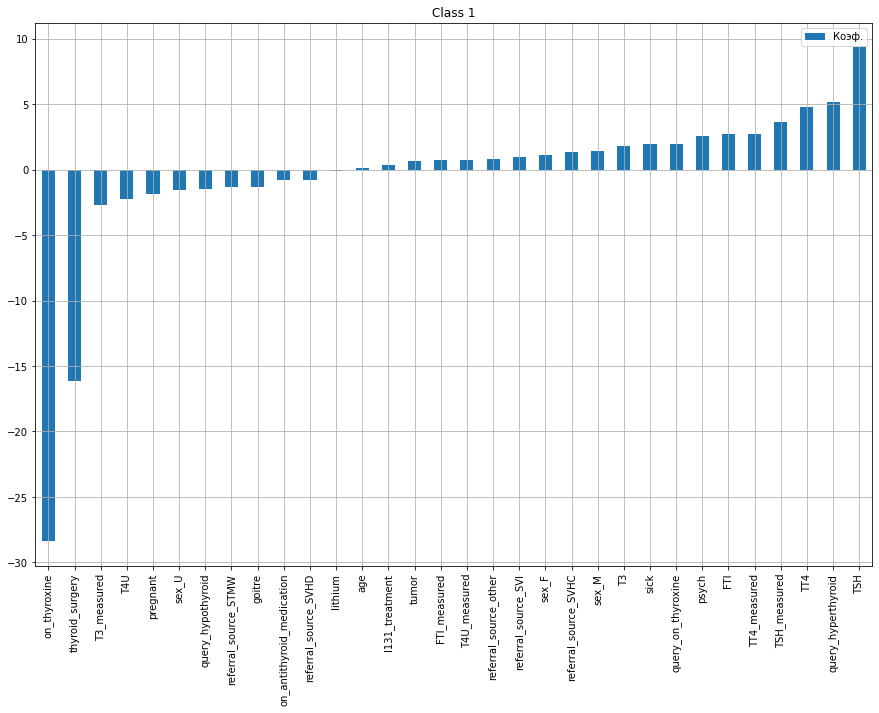

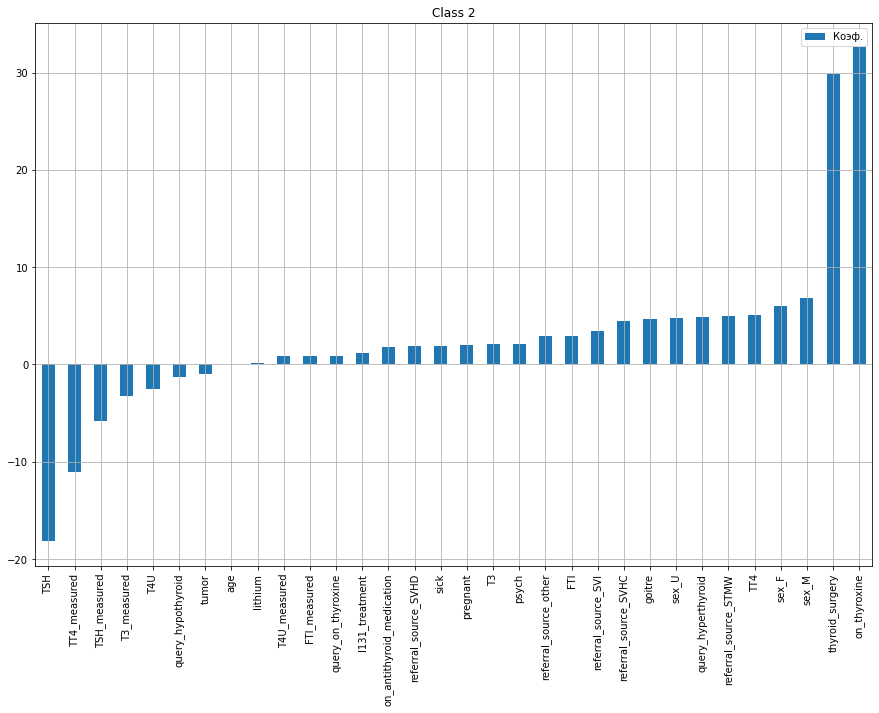

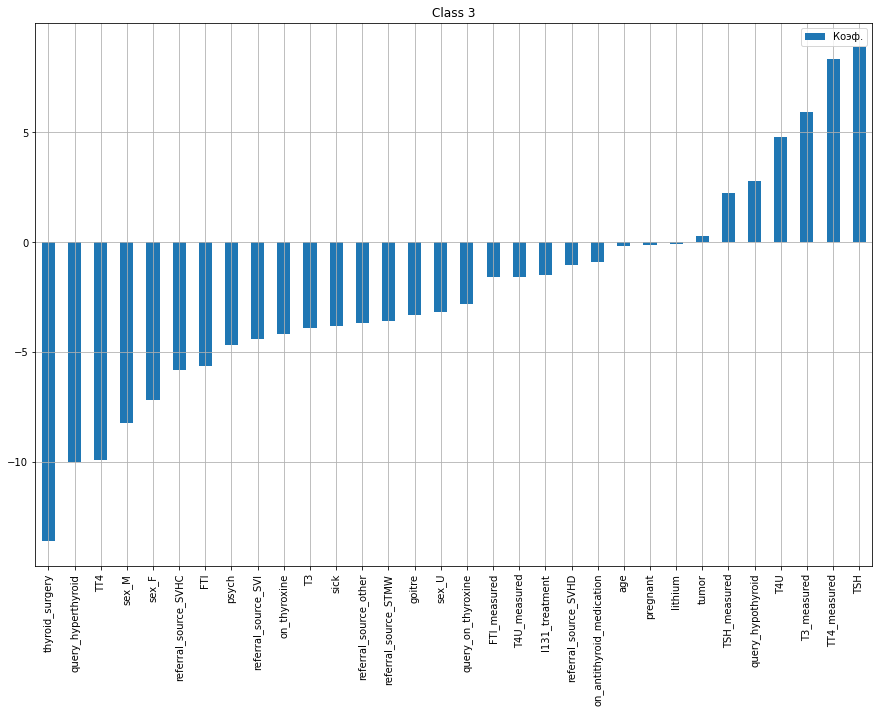

In [61]:
print('logloss ', log_loss(y_test, prob_preds))
print('Полнота ', recall_score(y_test, preds, average='macro'))
print('Точность ', precision_score(y_test, preds, average='macro'))
print('F1 ', f1_score(y_test, preds, average='macro'))
for i in range(3):
    coef = pd.DataFrame(logistic_pipeline[2].coef_[i], cols).sort_values(by=0)
    coef.columns = ['Коэф.']
    coef.plot.bar(grid=True, title='Сlass ' + str(i + 1), figsize=(15, 10))

## Логистическая регрессия с разными видами регуляризации


### L1

logloss 0.18051895238348853
Полнота  0.893821391484943
Точность  0.767888465493256
F1  0.8215826707843266


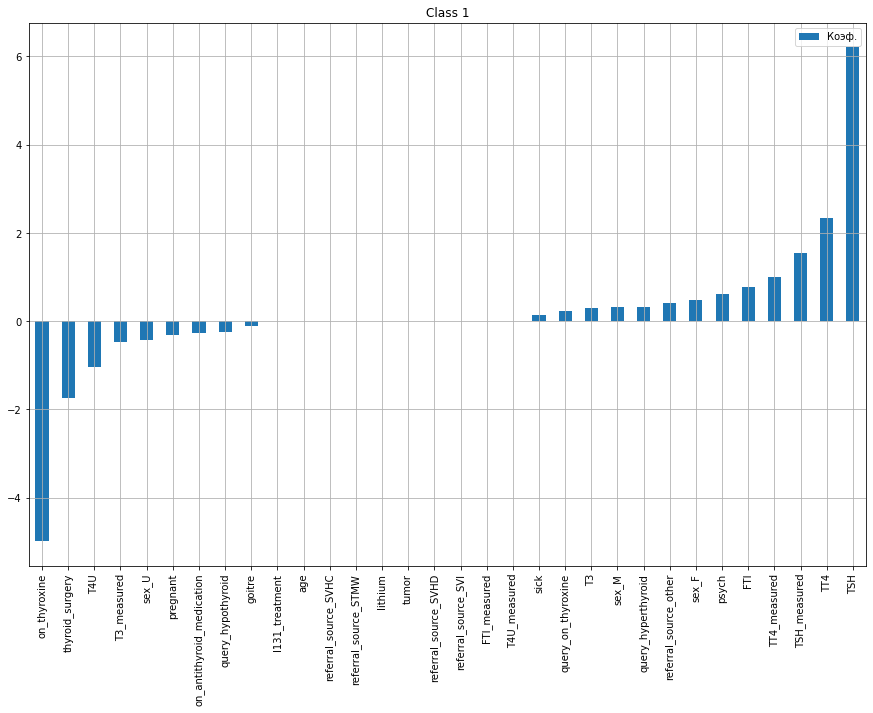

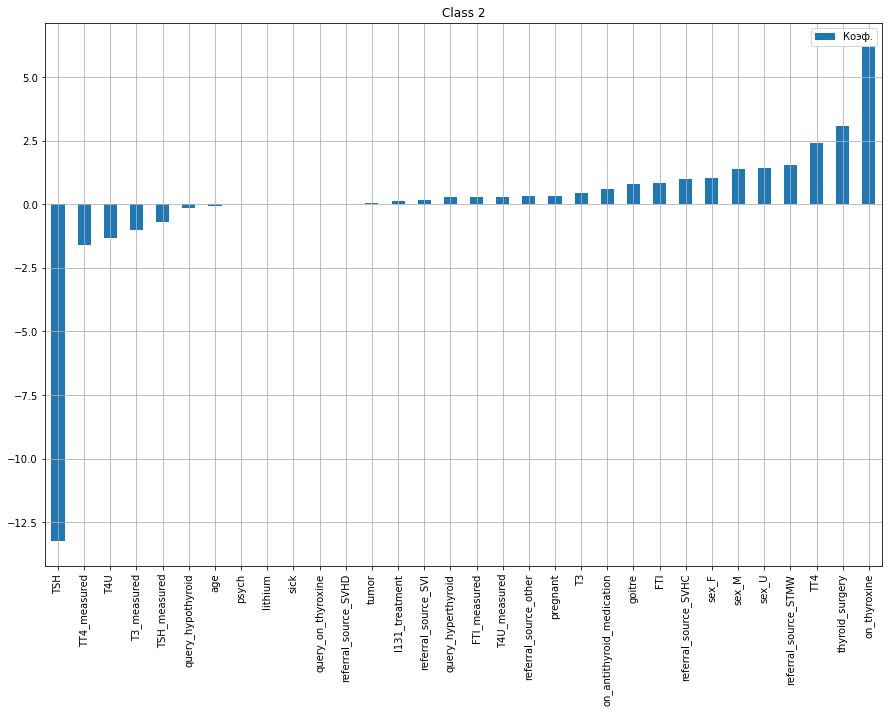

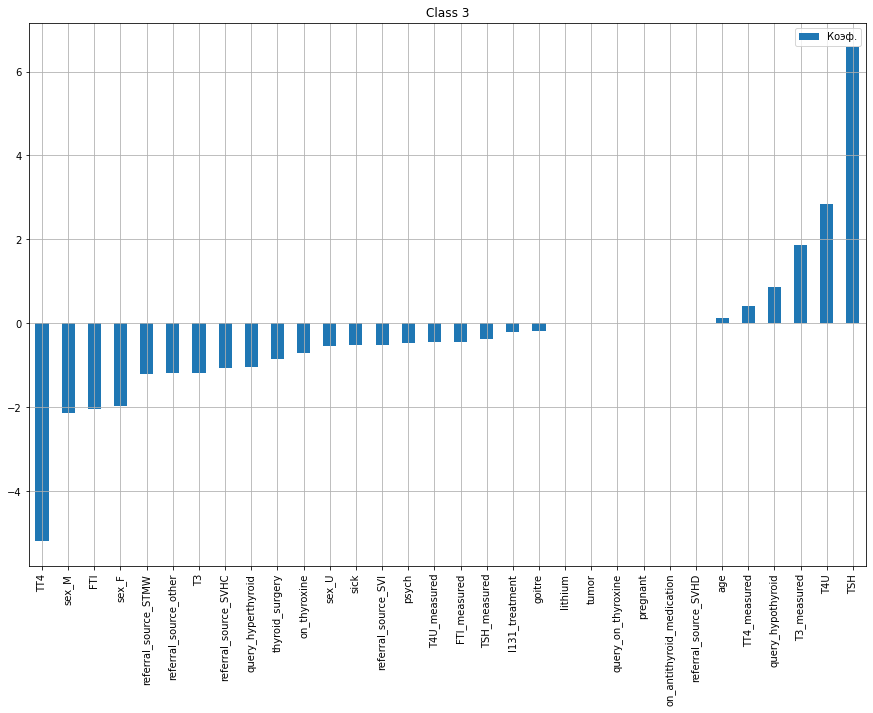

In [62]:
model = LogisticRegression(solver = 'saga' ,penalty='l1', random_state=SEED, class_weight='balanced')
logistic_pipeline = imblearn.pipeline.Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('SMOTE', smt),
    ('model', model)
])
logistic_pipeline.fit(X_train, y_train)
prob_preds = logistic_pipeline.predict_proba(X_test)
print('logloss', log_loss(y_test, prob_preds))
print('Полнота ', recall_score(y_test, preds, average='macro'))
print('Точность ',precision_score(y_test, preds, average='macro'))
print('F1 ', f1_score(y_test, preds, average='macro'))
for i in range(3):
    coef = pd.DataFrame(logistic_pipeline[2].coef_[i], cols).sort_values(by=0)
    coef.columns = ['Коэф.']
    coef.plot.bar(grid=True, title='Сlass ' + str(i + 1), figsize=(15, 10))

In [63]:
model = LogisticRegression(penalty='l2', random_state=SEED)
logistic_pipeline = imblearn.pipeline.Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('SMOTE', smt),
    ('model', model)
])
logistic_pipeline.fit(X_train, y_train)
preds = logistic_pipeline.predict(X_test)
prob_preds = logistic_pipeline.predict_proba(X_test)
print('logloss', log_loss(y_test, prob_preds))
print('Полнота ', recall_score(y_test, preds, average='macro'))
print('Точность ',precision_score(y_test, preds, average='macro'))
print('F1 ', f1_score(y_test, preds, average='macro'))


logloss 0.18212144079807788
Полнота  0.9281542056074766
Точность  0.78359212537474
F1  0.8442699525191912


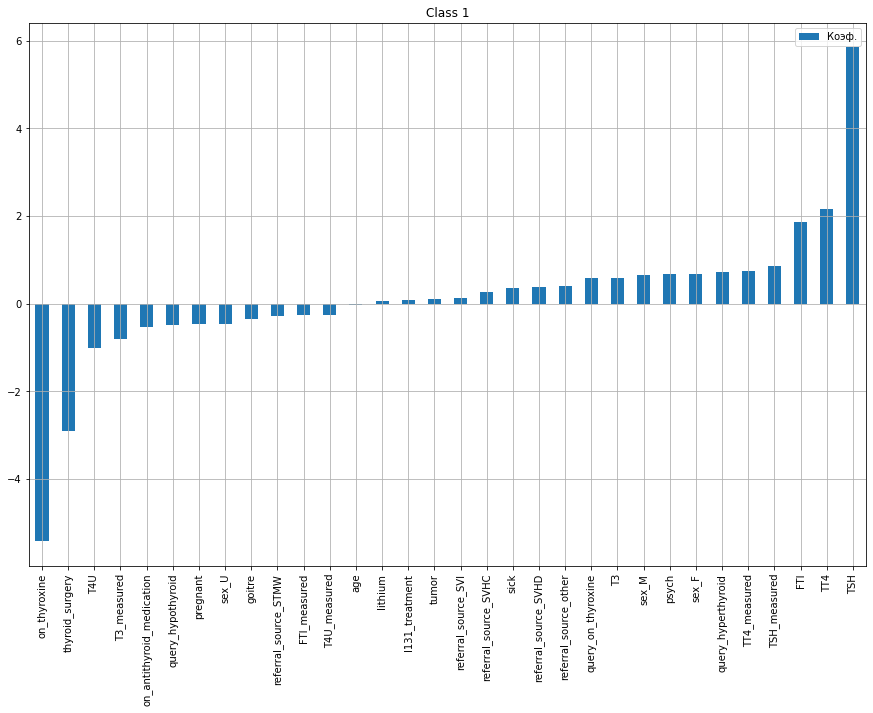

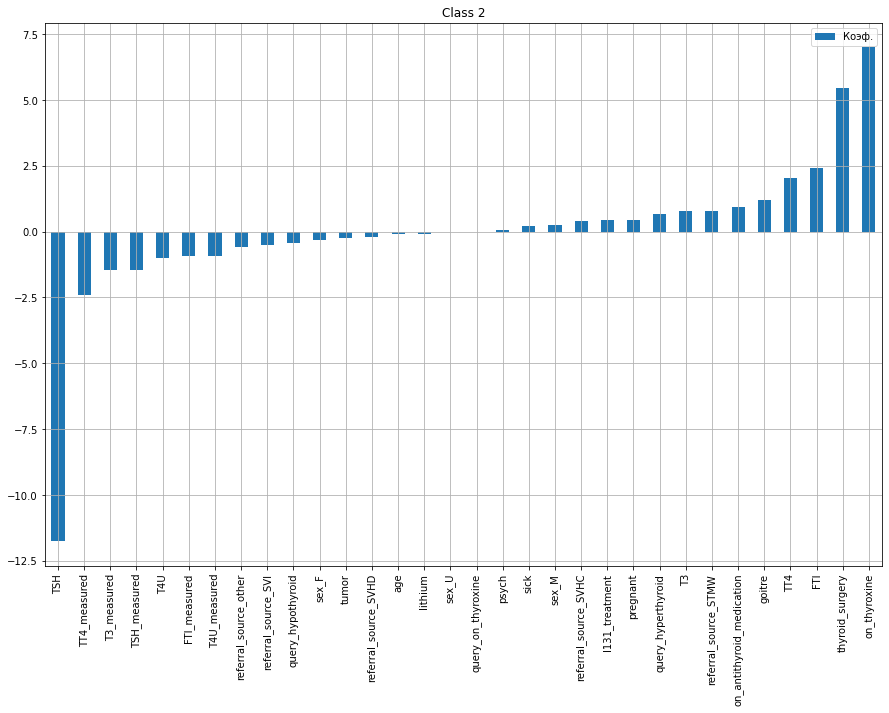

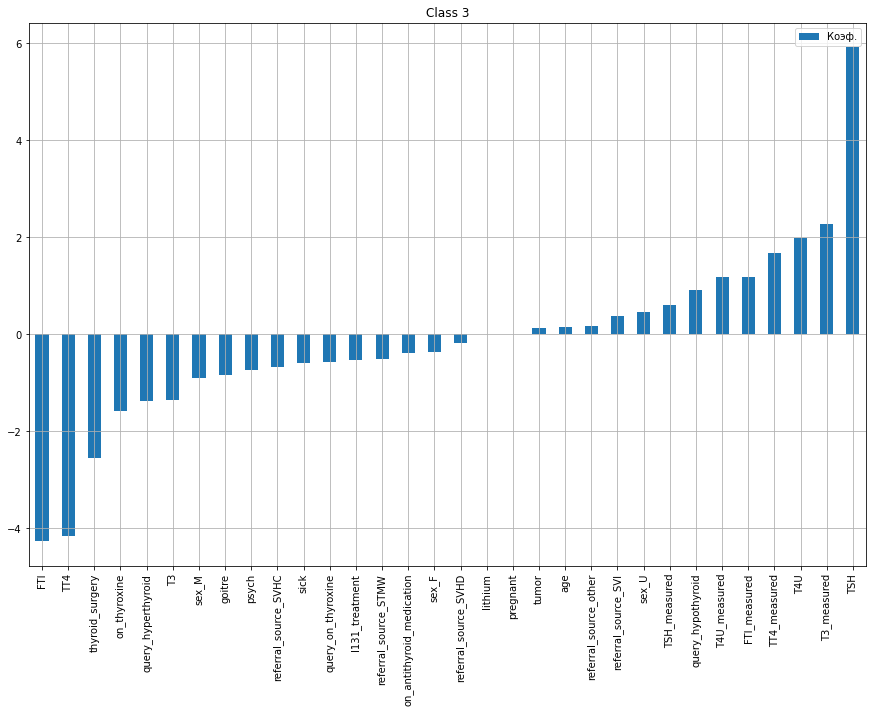

In [65]:
for i in range(3):
    coef = pd.DataFrame(logistic_pipeline[2].coef_[i], cols).sort_values(by=0)
    coef.columns = ['Коэф.']
    coef.plot.bar(grid=True, title='Сlass ' + str(i + 1), figsize=(15, 10))

###  Elastic net

In [67]:
model = LogisticRegression(solver = 'saga' ,penalty='elasticnet', l1_ratio=0.5, random_state=SEED, class_weight='balanced')
logistic_pipeline = imblearn.pipeline.Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('SMOTE', smt),
    ('model', model)
])
logistic_pipeline.fit(X_train, y_train)
preds = logistic_pipeline.predict(X_test)
prob_preds = logistic_pipeline.predict_proba(X_test)
print('logloss', log_loss(y_test, prob_preds))
print('Полнота ', recall_score(y_test, preds, average='macro'))
print('Точность ',precision_score(y_test, preds, average='macro'))
print('F1 ', f1_score(y_test, preds, average='macro'))

logloss 0.1854696747758211
Полнота  0.9262071651090342
Точность  0.7586421825552261
F1  0.8260905077812519


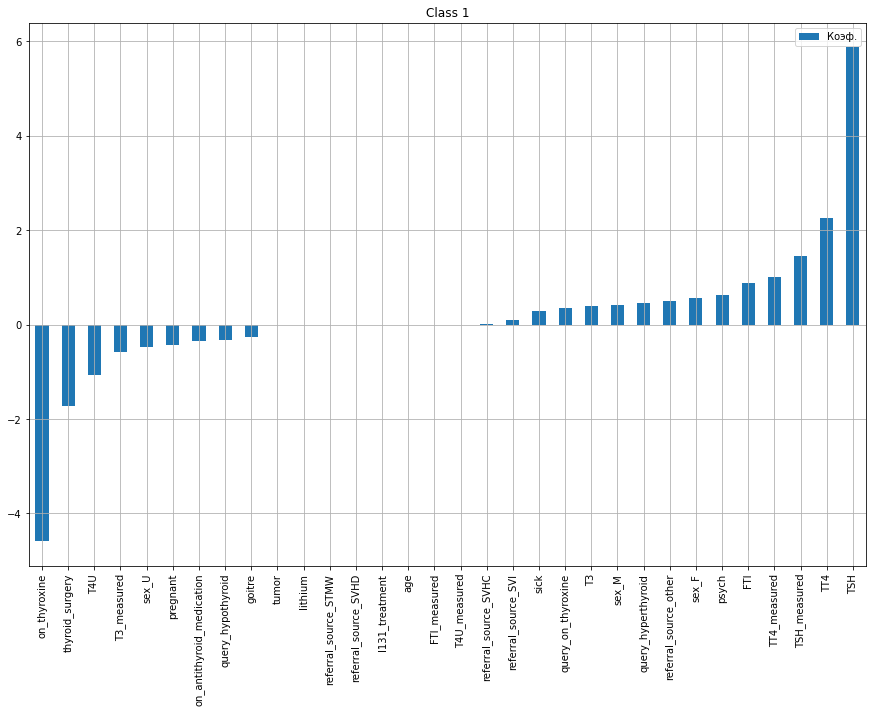

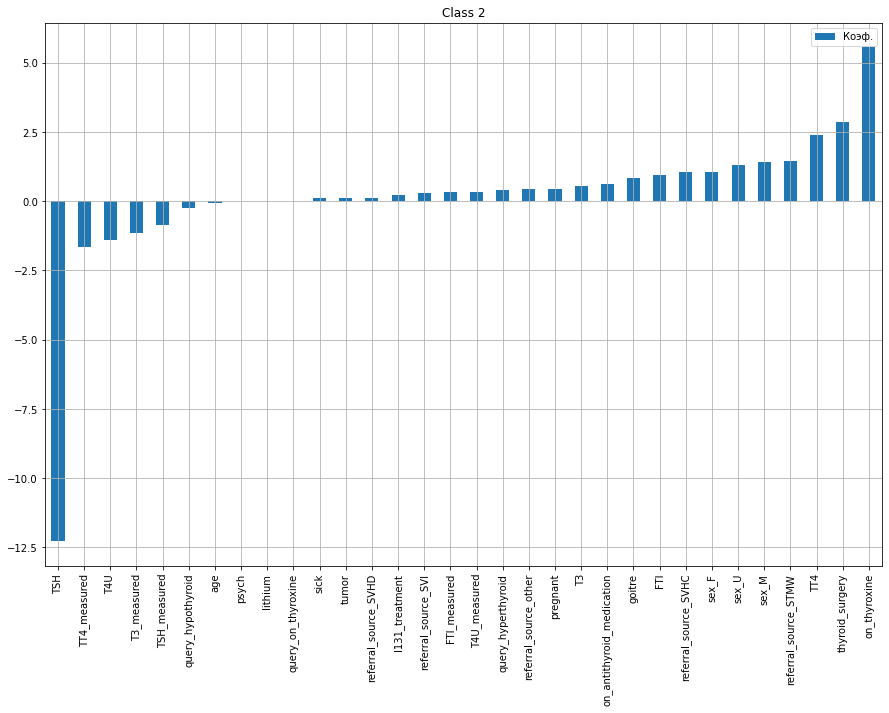

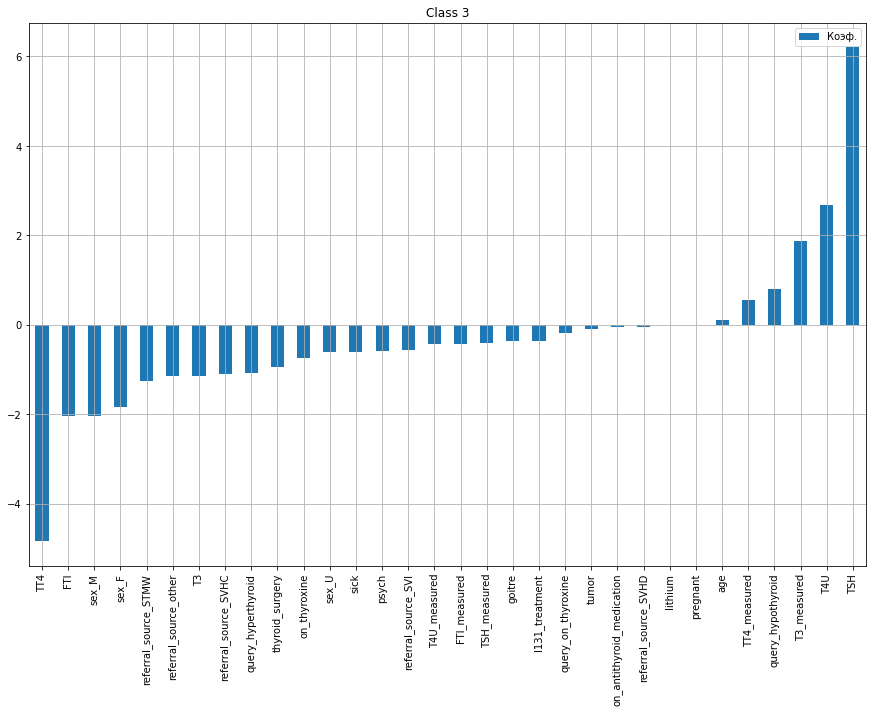

In [68]:
for i in range(3):
    coef = pd.DataFrame(logistic_pipeline[2].coef_[i], cols).sort_values(by=0)
    coef.columns = ['Коэф.']
    coef.plot.bar(grid=True, title='Сlass ' + str(i + 1), figsize=(15, 10))

## Выводы
Так как в задаче речь идет о здоровье человека, в этом случае будет выгодным взять модель с регуляризацией <b>L2</b>, так как этот вариант имеет наибольшую полноту, то есть наилучшим образом определяет больных. 

## Выводы по feature importance

Самые важные параметры для опредления заболевания у пациента:
- TSH
- FTI
- TT4
- T3
- Bool features (flags)
- on_thyroxine

То есть:
- гормональные уровни пациента
- произведение двух важных показателей при анализе крови TT4 (есть в выборке) и T3U(нет в выборке)
- Показатели при анализе крови 
- И логические переменные, относительно есть ли данные по выше указанным столбцам
- Проходит ли лечение пациент



- Мужчины более склоны к заболеваниям щитовидной железы
- Для здоровых людей важен параметр thyroid_surgery, то есть, большинство людей перенесших операцию вылечелись от заболевания



## Подбор гиперпараметров для Elsatic net

In [101]:
cv = StratifiedKFold(5, random_state=SEED)
tuning_param = {
    'model__l1_ratio': np.arange(0, 1, 0.05),
    'model__C': [1e-5, 1e-3, 1e-1, 1e1, 1e3],
    'model__max_iter': range(50, 200, 50),
   }

In [103]:
clf = GridSearchCV(logistic_pipeline, cv=cv, scoring='recall_macro', param_grid=tuning_param)
clf.fit(X_train, y_train)

In [73]:
clf.best_params_

{'model__C': 10.0, 'model__max_iter': 120}

In [74]:
preds = clf.predict(X_test)

In [75]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.73      0.90      0.80        48
           1       1.00      0.97      0.99       856
           2       0.65      0.92      0.76        24

    accuracy                           0.97       928
   macro avg       0.79      0.93      0.85       928
weighted avg       0.97      0.97      0.97       928



# KNN

In [82]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

model = KNeighborsClassifier(weights='distance')
KNN_pipeline = imblearn.pipeline.Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('SMOTE', smt),
    ('model', model)
])

KNN_pipeline.fit(X_train, y_train)
preds=KNN_pipeline.predict(X_test)
prob_preds = KNN_pipeline.predict_proba(X_test)
print('logloss', log_loss(y_test, prob_preds))
print('Полнота ', recall_score(y_test, preds, average='macro'))
print('Точность ',precision_score(y_test, preds, average='macro'))
print('F1 ', f1_score(y_test, preds, average='macro'))


logloss 1.8726235370389674
Полнота  0.7172897196261682
Точность  0.6744609246564041
F1  0.6805111241146303


In [83]:
cv = StratifiedKFold(5, random_state=SEED)
tuning_param = {
    'model__leaf_size': range(20, 40) ,
    'model__n_neighbors': range(3, 21, 2),
    'model__p': range(1, 3)
   }

In [84]:
clf = GridSearchCV(KNN_pipeline, cv=cv, scoring='recall_macro', param_grid=tuning_param)
clf.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=13, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'TSH',
                                                                          'T3',
                                                                          'TT4',
                           

In [85]:
clf.best_params_

{'model__leaf_size': 20, 'model__n_neighbors': 17, 'model__p': 1}

In [87]:
preds = clf.predict(X_test)

In [88]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.19      0.54      0.28        48
           1       0.98      0.87      0.92       856
           2       0.73      0.79      0.76        24

    accuracy                           0.85       928
   macro avg       0.63      0.74      0.65       928
weighted avg       0.93      0.85      0.88       928



In [89]:
from shap import KernelExplainer
import shap

In [92]:
expl_data =  pd.DataFrame(preprocessor.transform(X_train))
expl_test_data =  pd.DataFrame(preprocessor.transform(X_test))


model = KNeighborsClassifier(leaf_size=20, n_neighbors=3, p=1)
expl_test_data.columns = get_column_names_from_column_transformer(preprocessor, X_train.columns)[:-1]

expl_data.columns = get_column_names_from_column_transformer(preprocessor, X_train.columns)[:-1]
model.fit(expl_data, y_train)

KNeighborsClassifier(leaf_size=20, n_neighbors=3, p=1)

In [93]:
shap.initjs()

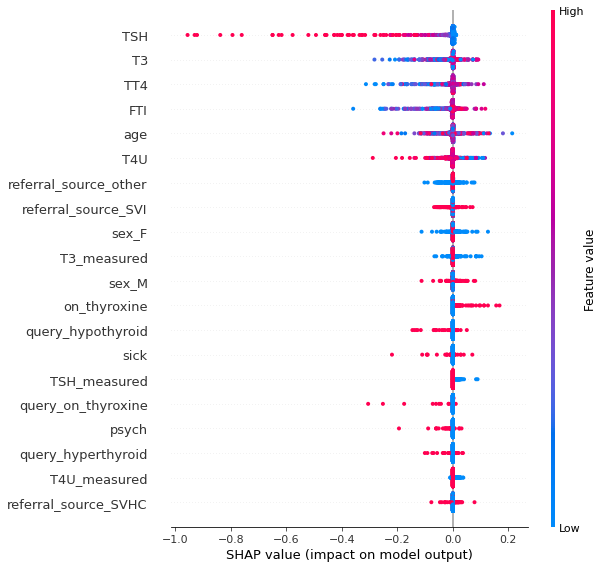

In [94]:
f = lambda x: model.predict_proba(x)[:,1]

med = expl_data.median().values.reshape((1, expl_data.shape[1]))
explainer = KernelExplainer(f, med)
shap_values  = explainer.shap_values(expl_data.iloc[0:1000,:], nsamples=1000)
shap.summary_plot(shap_values, expl_data.iloc[0:1000,:])

## Дополнение к Feature importance по Лог. регресии
- возраст, который не так сильно учитывается первой моделью.

- На этом отчетливее графике видно, что пациенты-мужчины более подвержены болезням щитовидной железы, чем пациенты-женщины

## Сравнение under/over sampling на логистической регрессии

In [96]:
from imblearn.under_sampling import EditedNearestNeighbours as ENN

enn = ENN()

model = LogisticRegression(penalty='l2', class_weight='balanced', random_state=SEED)
logistic_pipeline = imblearn.pipeline.Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('SMOTE', enn),
    ('model', model)
])
logistic_pipeline.fit(X_train, y_train)
preds = logistic_pipeline.predict(X_test)
prob_preds = logistic_pipeline.predict_proba(X_test)
print('logloss', log_loss(y_test, prob_preds))
print('Полнота ', recall_score(y_test, preds, average='macro'))
print('Точность ',precision_score(y_test, preds, average='macro'))
print('F1 ', f1_score(y_test, preds, average='macro'))


logloss 0.30260393170072364
Полнота  0.6538811007268951
Точность  0.5946183953033267
F1  0.5804155274171998


In [97]:
model = LogisticRegression(penalty='l2', class_weight='balanced', random_state=SEED)
logistic_pipeline = imblearn.pipeline.Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('SMOTE', smt),
    ('model', model)
])
logistic_pipeline.fit(X_train, y_train)
preds = logistic_pipeline.predict(X_test)
prob_preds = logistic_pipeline.predict_proba(X_test)
print('logloss', log_loss(y_test, prob_preds))
print('Полнота ', recall_score(y_test, preds, average='macro'))
print('Точность ',precision_score(y_test, preds, average='macro'))
print('F1 ', f1_score(y_test, preds, average='macro'))


logloss 0.18212144079807788
Полнота  0.9281542056074766
Точность  0.78359212537474
F1  0.8442699525191912


In [98]:
from imblearn.combine import SMOTEENN

smteenn = SMOTEENN()

logistic_pipeline = imblearn.pipeline.Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('SMOTE', smteenn),
    ('model', model)
])
logistic_pipeline.fit(X_train, y_train)
preds = logistic_pipeline.predict(X_test)
prob_preds = logistic_pipeline.predict_proba(X_test)
print('logloss', log_loss(y_test, prob_preds))
print('Полнота ', recall_score(y_test, preds, average='macro'))
print('Точность ',precision_score(y_test, preds, average='macro'))
print('F1 ', f1_score(y_test, preds, average='macro'))

logloss 0.20576998866921292
Полнота  0.9454828660436138
Точность  0.7619047619047619
F1  0.8352563908433522
